# Compare WRF and Daymet Daily Minimum Temperatures

# 1. Import required Python libraries

In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import LC_Grid_Labels as lc
import cartopy
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import wrf
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import IPython

## 1. a.  Print session and library version numbers

In [2]:
# Print IPython Session Info
print(IPython.sys_info())

# Print versions of libraries used in this notebook for traceability
print("\nPackage version numbers:\n")
print("xarray version: " + xr.__version__)
print("numpy version: " + np.__version__)
print("scipy version: " + scipy.__version__)
print("matplotlib version: " + matplotlib.__version__)
print("cartopy: " + cartopy.__version__)
print("wrf-python version: " + wrf.__version__+"\n")

{'commit_hash': '8c47bbcb3',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/Users/lejoflores/miniconda3/lib/python3.7/site-packages/IPython',
 'ipython_version': '7.5.0',
 'os_name': 'posix',
 'platform': 'Darwin-18.6.0-x86_64-i386-64bit',
 'sys_executable': '/Users/lejoflores/miniconda3/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.7.3 (default, Mar 27 2019, 16:54:48) \n'
                '[Clang 4.0.1 (tags/RELEASE_401/final)]'}

Package version numbers:

xarray version: 0.12.1
numpy version: 1.16.3
scipy version: 1.2.1
matplotlib version: 3.0.3
cartopy: 0.17.0
wrf-python version: 1.3.2



# 2. Read in data using ```xarray```

In [3]:
wrf_dir = '/Users/lejoflores/data/WRF-NARR-1km-Daily/'

ds_wrf = xr.open_mfdataset(wrf_dir+'WRF-NARR*.nc')
print(ds_wrf)

daymet_dir = '/Users/lejoflores/data/Regridded_DayMet_ID/d02/tmin/'

ds_daymet = xr.open_mfdataset(daymet_dir+'DayMetRegrid_tmin_*.nc')
print(ds_daymet)

<xarray.Dataset>
Dimensions:  (XTIME: 10958, south_north: 327, west_east: 348)
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 1987-10-01 1987-10-02 ... 2017-09-30
Dimensions without coordinates: south_north, west_east
Data variables:
    DPRCP    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMEAN    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    Q2       (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWDOWN   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWNORM   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMIN     (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMAX     (XTIME, south_north, west_east) float32 dask.array<shap

## 2. b. Select the periods of overlap for both datasets

In [4]:
ds_wrf2 = ds_wrf.sel(XTIME=slice('1987-10-01','2017-09-30'))
print(ds_wrf2)

ds_daymet2 = ds_daymet.sel(time=slice('1987-10-01','2017-09-30'))
print(ds_daymet2)


<xarray.Dataset>
Dimensions:  (XTIME: 10958, south_north: 327, west_east: 348)
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 1987-10-01 1987-10-02 ... 2017-09-30
Dimensions without coordinates: south_north, west_east
Data variables:
    DPRCP    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMEAN    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    Q2       (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWDOWN   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWNORM   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMIN     (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMAX     (XTIME, south_north, west_east) float32 dask.array<shap

## 2. c. Create a month of the water year array to use as a grouping variable for both datasets

In [5]:
WY1_wrf = (ds_wrf2['XTIME.year'].where(ds_wrf2['XTIME.month'] >= 10).values + 1)
WY2_wrf = (ds_wrf2['XTIME.year'].where(ds_wrf2['XTIME.month'] < 10).values)
WY_wrf = np.nansum(np.column_stack((WY1_wrf,WY2_wrf)),axis=1)

WY_MO_wrf = ds_wrf2['XTIME.month'].values - 9
WY_MO_wrf[WY_MO_wrf<=0] += 12

In [6]:
WY1_dm = (ds_daymet2['time.year'].where(ds_daymet2['time.month'] >= 10).values + 1)
WY2_dm = (ds_daymet2['time.year'].where(ds_daymet2['time.month'] < 10).values)
WY_dm = np.nansum(np.column_stack((WY1_dm,WY2_dm)),axis=1)

WY_MO_dm = ds_daymet2['time.month'].values - 9
WY_MO_dm[WY_MO_dm<=0] += 12

## 2. d. Append Water Year grouping vectors to WRF and Daymet datasets

In [7]:
ds_wrf2.coords['WY'] = xr.DataArray(WY_wrf.astype(int),dims='XTIME')
ds_wrf2.coords['WY_MO'] = xr.DataArray(WY_MO_wrf.astype(int),dims='XTIME')
print(ds_wrf)

ds_daymet2.coords['WY'] = xr.DataArray(WY_dm.astype(int),dims='time')
ds_daymet2.coords['WY_MO'] = xr.DataArray(WY_MO_dm.astype(int),dims='time')
print(ds_daymet2)

<xarray.Dataset>
Dimensions:  (XTIME: 10958, south_north: 327, west_east: 348)
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 1987-10-01 1987-10-02 ... 2017-09-30
Dimensions without coordinates: south_north, west_east
Data variables:
    DPRCP    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMEAN    (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    Q2       (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWDOWN   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    SWNORM   (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMIN     (XTIME, south_north, west_east) float32 dask.array<shape=(10958, 327, 348), chunksize=(366, 327, 348)>
    TMAX     (XTIME, south_north, west_east) float32 dask.array<shap

# 3. Get seasonal long-term seasonal mean daily minimum temperature for WRF and Daymet  

In [8]:
wrf_tmin_OND = ds_wrf2.TMIN[ds_wrf2.WY_MO.values<=3].groupby('WY').mean(dim='XTIME')
wrf_tmin_JFM = ds_wrf2.TMIN[(ds_wrf2.WY_MO.values > 3) & (ds_wrf2.WY_MO.values <= 6)].groupby('WY').mean(dim='XTIME')
wrf_tmin_AMJ = ds_wrf2.TMIN[(ds_wrf2.WY_MO.values > 6) & (ds_wrf2.WY_MO.values <= 9)].groupby('WY').mean(dim='XTIME')
wrf_tmin_JAS = ds_wrf2.TMIN[ds_wrf2.WY_MO.values > 9].groupby('WY').mean(dim='XTIME')

daymet_tmin_OND = ds_daymet2.tmin[ds_daymet2.WY_MO.values<=3].groupby('WY').mean(dim='time')
daymet_tmin_JFM = ds_daymet2.tmin[(ds_daymet2.WY_MO.values > 3) & (ds_daymet2.WY_MO.values <= 6)].groupby('WY').mean(dim='time')
daymet_tmin_AMJ = ds_daymet2.tmin[(ds_daymet2.WY_MO.values > 6) & (ds_daymet2.WY_MO.values <= 9)].groupby('WY').mean(dim='time')
daymet_tmin_JAS = ds_daymet2.tmin[ds_daymet2.WY_MO.values > 9].groupby('WY').mean(dim='time')

tmin_diff_OND = (wrf_tmin_OND.values - 273.15) - daymet_tmin_OND.values
tmin_diff_JFM = (wrf_tmin_JFM.values - 273.15) - daymet_tmin_JFM.values
tmin_diff_AMJ = (wrf_tmin_AMJ.values - 273.15) - daymet_tmin_AMJ.values
tmin_diff_JAS = (wrf_tmin_JAS.values - 273.15) - daymet_tmin_JAS.values


# 4. Create plots characterizing differences between WRF and Daymet daily minimum temperature

In [9]:
ds_wrfgeo = xr.open_dataset(wrf_dir+'wrf_geoinfo.nc')
nc_wrfgeo = nc.Dataset(wrf_dir+'wrf_geoinfo.nc')
cart_proj = get_cartopy(wrfin=nc_wrfgeo)

lats, lons = latlon_coords(ds_wrfgeo)

lat = lats[0]
lon = lons[0]

states = NaturalEarthFeature(category='cultural', scale='10m',facecolor='none',name='admin_1_states_provinces_shp')
rivers = NaturalEarthFeature(category='physical',scale='10m',facecolor='none',name='rivers_lake_centerlines')

plt.rcParams.update({'font.size': 12, 'font.family':'sans-serif'})

xticks = [-118,-117,-116,-115,-114,-113]
yticks = [42,43,44,45,46]

fig_ids = ['(a) OND','(b) JFM',
           '(c) AMJ','(d) JAS']

figsize_in = (13,13)
figres_dpi = 300
figext = '.tif'

contour_levels = 15

TminAvgDiff_fname = 'fig/17_TminWRF_Daymet_AvgDiff'+figext
TminStdDiff_fname = 'fig/18_TminWRF_Daymet_StdDiff'+figext
TminAnnScat_fname = 'fig/S2_TminAnnWRFvsDaymet'+figext
TminHexBin_fname  = 'fig/19_TminWRF_Daymet_hexbin'+figext

## 4. a. Plot difference in seasonal average daily minimum temperature

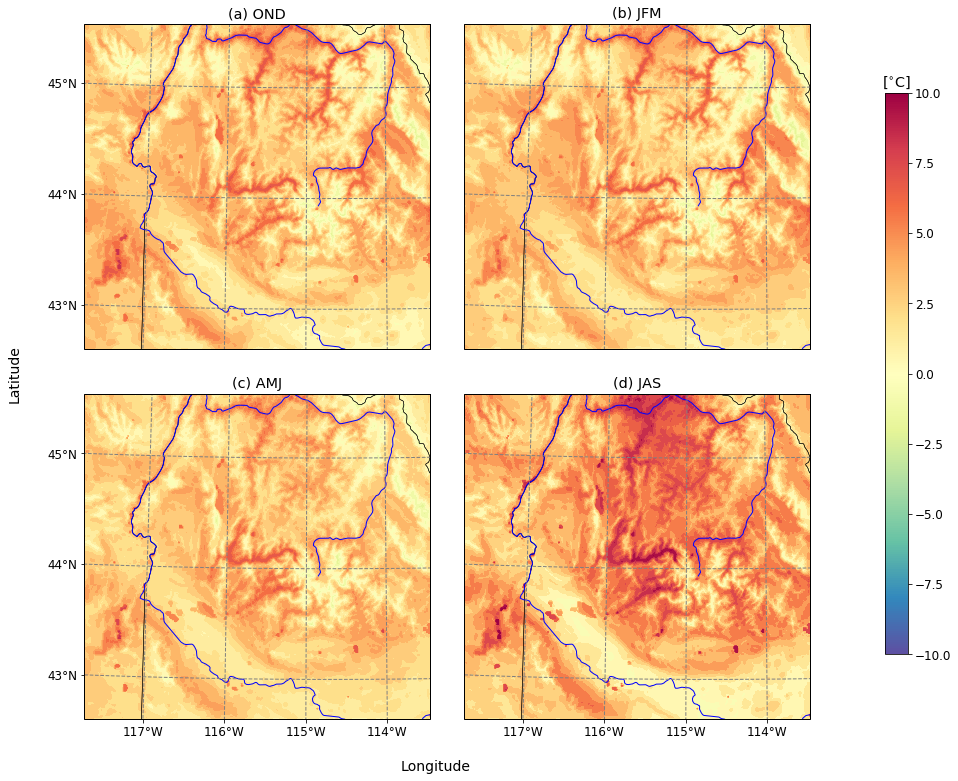

In [10]:
vmin_tmin = -10.0
vmax_tmin = 10.0

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize_in, subplot_kw = {'projection': cart_proj})
fig.subplots_adjust(wspace = .1, hspace = .1)

im11 = axes[0][0].contourf(to_np(lon),to_np(lat),np.mean(tmin_diff_OND,axis=0),contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im12 = axes[0][1].contourf(to_np(lon),to_np(lat),np.mean(tmin_diff_JFM,axis=0),contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im21 = axes[1][0].contourf(to_np(lon),to_np(lat),np.mean(tmin_diff_AMJ,axis=0),contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im22 = axes[1][1].contourf(to_np(lon),to_np(lat),np.mean(tmin_diff_JAS,axis=0),contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')

FigIter = 0
for ax in axes.flat:
    ax.add_feature(states, linewidth=0.5, edgecolor='black')
    ax.add_feature(rivers, linewidth=1.0, edgecolor='b')
    fig.canvas.draw()
    ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', linestyle='--', linewidth=1)
    ax.set_title(fig_ids[FigIter])
    
    if(ax.rowNum==1):
        ax.xaxis.set_major_formatter(lc.LONGITUDE_FORMATTER) 
        lc.lambert_xticks(ax, xticks)
    
    if(ax.colNum==0):
        ax.yaxis.set_major_formatter(lc.LATITUDE_FORMATTER)
        lc.lambert_yticks(ax, yticks)

    FigIter += 1
    
fig.text(0.5, 0.08, 'Longitude', ha='center', va='center', fontsize=14)
fig.text(0.05, 0.5, 'Latitude', ha='center', va='center', rotation='vertical', fontsize=14)

cbar_ax = fig.add_axes([0.98, 0.2, 0.025, 0.6],in_layout=False)

m = plt.cm.ScalarMappable(cmap=cm.Spectral_r)
m.set_array(to_np(tmin_diff_OND))
m.set_clim(vmin_tmin, vmax_tmin)
clb = fig.colorbar(m,cax = cbar_ax)
clb.ax.set_title('[${}^{\circ}$C]')

plt.savefig(TminAvgDiff_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', 
            orientation='portrait', bbox_inches='tight')
plt.show()

## 4. b. Plot the interannual variability in the difference between WRF and Daymet seasonal daily minimum temperature

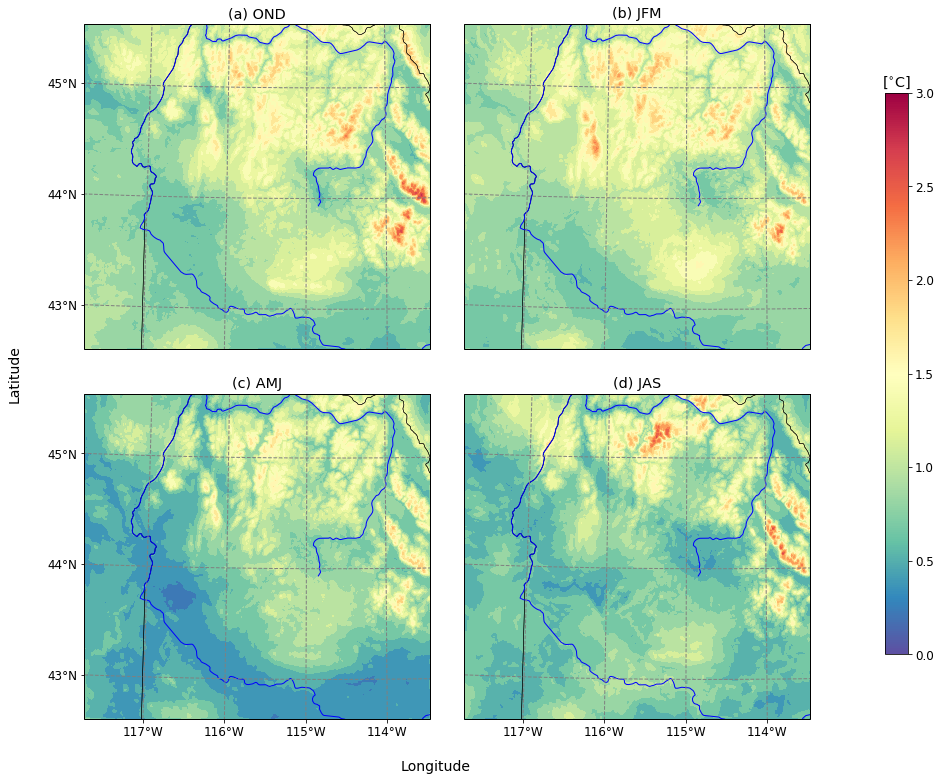

In [11]:
vmin_tmin = 0.0
vmax_tmin = 3.0

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize_in, subplot_kw = {'projection': cart_proj})
fig.subplots_adjust(wspace = .1, hspace = .1)

im11 = axes[0][0].contourf(to_np(lon),to_np(lat),np.std(tmin_diff_OND,axis=0),contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im12 = axes[0][1].contourf(to_np(lon),to_np(lat),np.std(tmin_diff_JFM,axis=0),contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im21 = axes[1][0].contourf(to_np(lon),to_np(lat),np.std(tmin_diff_AMJ,axis=0),contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')
im22 = axes[1][1].contourf(to_np(lon),to_np(lat),np.std(tmin_diff_JAS,axis=0),contour_levels,transform=crs.PlateCarree(),
                           vmin=vmin_tmin,vmax=vmax_tmin,cmap='Spectral_r')

FigIter = 0
for ax in axes.flat:
    ax.add_feature(states, linewidth=0.5, edgecolor='black')
    ax.add_feature(rivers, linewidth=1.0, edgecolor='b')
    fig.canvas.draw()
    ax.gridlines(xlocs=xticks, ylocs=yticks, color='gray', linestyle='--', linewidth=1)
    ax.set_title(fig_ids[FigIter])
    
    if(ax.rowNum==1):
        ax.xaxis.set_major_formatter(lc.LONGITUDE_FORMATTER) 
        lc.lambert_xticks(ax, xticks)
    
    if(ax.colNum==0):
        ax.yaxis.set_major_formatter(lc.LATITUDE_FORMATTER)
        lc.lambert_yticks(ax, yticks)

    FigIter += 1
    
fig.text(0.5, 0.08, 'Longitude', ha='center', va='center', fontsize=14)
fig.text(0.05, 0.5, 'Latitude', ha='center', va='center', rotation='vertical', fontsize=14)

cbar_ax = fig.add_axes([0.98, 0.2, 0.025, 0.6],in_layout=False)

m = plt.cm.ScalarMappable(cmap=cm.Spectral_r)
m.set_array(to_np(tmin_diff_OND))
m.set_clim(vmin_tmin, vmax_tmin)
clb = fig.colorbar(m,cax = cbar_ax)
clb.ax.set_title('[${}^{\circ}$C]')

plt.savefig(TminStdDiff_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', 
            orientation='portrait', bbox_inches='tight')
plt.show()

## 4. c. Plot the domain-wide average seasonal minimum temperature for each year

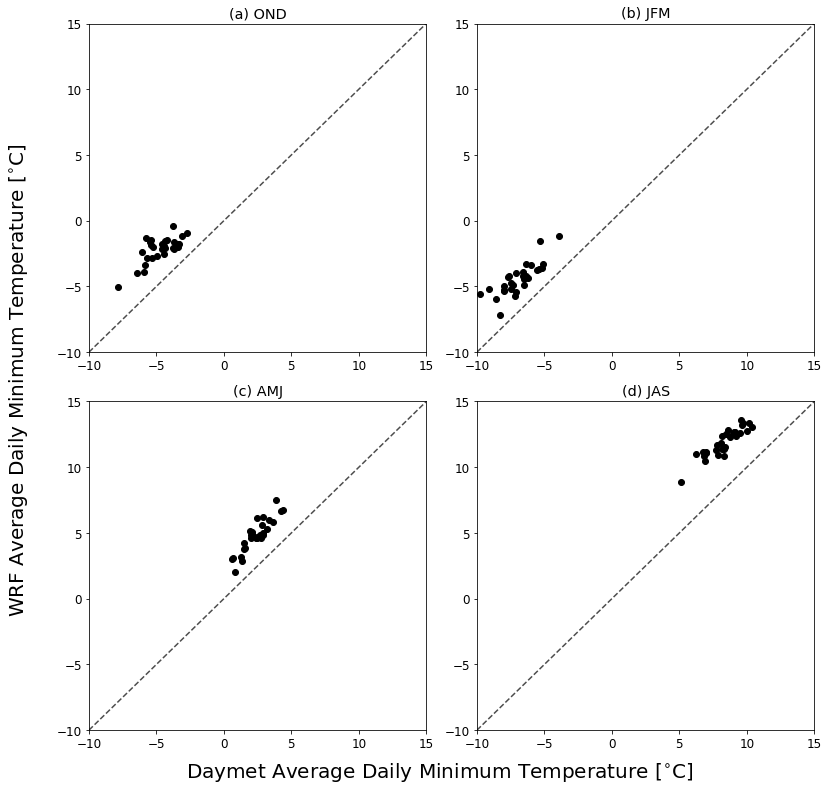

In [12]:

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize_in)
fig.subplots_adjust(wspace = .15, hspace = .15)

im11 = axes[0][0].plot(daymet_tmin_OND.mean(dim=('south_north','west_east')).values, 
                       wrf_tmin_OND.mean(dim=('south_north','west_east')).values - 273.15,'ko')
im12 = axes[0][1].plot(daymet_tmin_JFM.mean(dim=('south_north','west_east')).values, 
                       wrf_tmin_JFM.mean(dim=('south_north','west_east')).values - 273.15,'ko')
im21 = axes[1][0].plot(daymet_tmin_AMJ.mean(dim=('south_north','west_east')).values, 
                       wrf_tmin_AMJ.mean(dim=('south_north','west_east')).values - 273.15,'ko')
im22 = axes[1][1].plot(daymet_tmin_JAS.mean(dim=('south_north','west_east')).values, 
                       wrf_tmin_JAS.mean(dim=('south_north','west_east')).values - 273.15,'ko')

FigIter = 0

for ax in axes.flat:
    ax.set(xlim=(-10, 15), ylim=(-10, 15))
    diag_line = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    ax.set_title(fig_ids[FigIter])

    FigIter += 1
    
fig.text(0.5, 0.08, 'Daymet Average Daily Minimum Temperature [${}^{\circ}$C]', ha='center', va='center', fontsize=20)
fig.text(0.05, 0.5, 'WRF Average Daily Minimum Temperature [${}^{\circ}$C]', ha='center', va='center', rotation='vertical', fontsize=20)

plt.savefig(TminAnnScat_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', 
            orientation='portrait', bbox_inches='tight')

plt.show()

## 4. d. Create a hexbin plot to compare domain-wide average daily minimum temperature between the two datasets

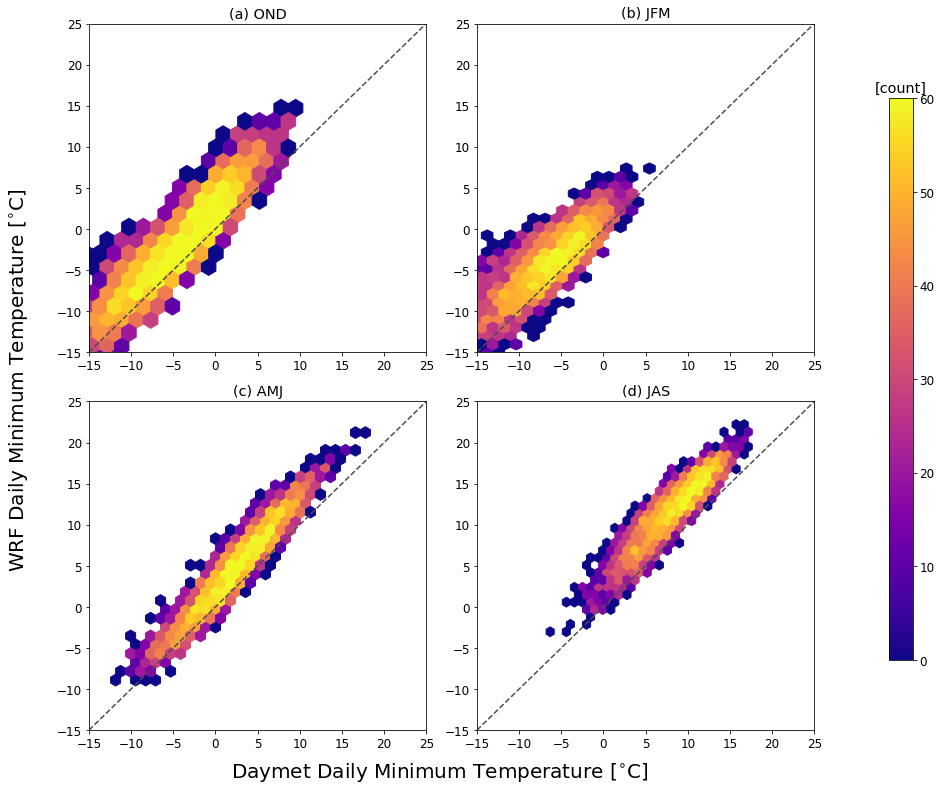

In [13]:
ds_wrf3 = ds_wrf2.sel(XTIME=ds_daymet2.time)

wrf_tmin_OND_daily = ds_wrf3.TMIN[ds_wrf3.WY_MO.values<=3] - 273.15
wrf_tmin_JFM_daily = ds_wrf3.TMIN[(ds_wrf3.WY_MO.values > 3) & (ds_wrf3.WY_MO.values <= 6)] - 273.15
wrf_tmin_AMJ_daily = ds_wrf3.TMIN[(ds_wrf3.WY_MO.values > 6) & (ds_wrf3.WY_MO.values <= 9)] - 273.15
wrf_tmin_JAS_daily = ds_wrf3.TMIN[ds_wrf3.WY_MO.values > 9] - 273.15

daymet_tmin_OND_daily = ds_daymet2.tmin[ds_daymet2.WY_MO.values<=3]
daymet_tmin_JFM_daily = ds_daymet2.tmin[(ds_daymet2.WY_MO.values > 3) & (ds_daymet2.WY_MO.values <= 6)]
daymet_tmin_AMJ_daily = ds_daymet2.tmin[(ds_daymet2.WY_MO.values > 6) & (ds_daymet2.WY_MO.values <= 9)]
daymet_tmin_JAS_daily = ds_daymet2.tmin[ds_daymet2.WY_MO.values > 9]

vmax_tmin = 60

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize_in)
fig.subplots_adjust(wspace = .15, hspace = .15)

im11 = axes[0][0].hexbin(daymet_tmin_OND_daily.mean(dim=('south_north','west_east')).values, 
                        wrf_tmin_OND_daily.mean(dim=('south_north','west_east')).values,gridsize=25,bins='log',
                        mincnt=1,vmax=vmax_tmin,cmap='plasma')
im12 = axes[0][1].hexbin(daymet_tmin_JFM_daily.mean(dim=('south_north','west_east')).values, 
                        wrf_tmin_JFM_daily.mean(dim=('south_north','west_east')).values,gridsize=25,bins='log',
                        mincnt=1,vmax=vmax_tmin,cmap='plasma')
im21 = axes[1][0].hexbin(daymet_tmin_AMJ_daily.mean(dim=('south_north','west_east')).values, 
                        wrf_tmin_AMJ_daily.mean(dim=('south_north','west_east')).values,gridsize=25,bins='log',
                        mincnt=1,vmax=vmax_tmin,cmap='plasma')
im22 = axes[1][1].hexbin(daymet_tmin_JAS_daily.mean(dim=('south_north','west_east')).values, 
                        wrf_tmin_JAS_daily.mean(dim=('south_north','west_east')).values,gridsize=25,bins='log',
                        mincnt=1,vmax=vmax_tmin,cmap='plasma')

FigIter = 0

for ax in axes.flat:
    ax.set(xlim=(-15, 25), ylim=(-15, 25))
    diag_line = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    ax.set_title(fig_ids[FigIter])

    FigIter += 1
    
cbar_ax = fig.add_axes([0.98, 0.2, 0.025, 0.6],in_layout=False)

m = plt.cm.ScalarMappable(cmap=cm.plasma)
m.set_array(im11)
m.set_clim(0, vmax_tmin)
clb = fig.colorbar(m,cax = cbar_ax)
clb.ax.set_title('[count]')

fig.text(0.5, 0.08, 'Daymet Daily Minimum Temperature [${}^{\circ}$C]', ha='center', va='center', fontsize=20)
fig.text(0.05, 0.5, 'WRF Daily Minimum Temperature [${}^{\circ}$C]', ha='center', va='center', rotation='vertical', fontsize=20)

plt.savefig(TminHexBin_fname, dpi=figres_dpi, facecolor='w', edgecolor='w', 
            orientation='portrait', bbox_inches='tight')

plt.show()